In [1]:
# COMMON IMPORTS
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, InjectedState
from langchain.tools import tool
from langchain_community.tools.file_management.read import ReadFileTool
#from langchain_experimental.tools.python.tool import PythonREPLTool
from pydantic import BaseModel, Field
from IPython.display import display, HTML, Image
from typing_extensions import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
import os
#import json
from dotenv import load_dotenv
from langchain_core.messages import ( HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage)
#import subprocess

from langgraph.graph.message import add_messages 

import pandas as pd
load_dotenv()

/home/aidodo/Foundations_of_AgenticAI/agentic-labs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


True

In [2]:
df = pd.read_csv('mbpp_san_train.csv', usecols=['task_id','prompt','code','test_list'])
df.head()

,task_id,prompt,code,test_list
0,602,Write a python function to find the first repe...,"def first_repeated_char(str1):\n for index,c ...","['assert first_repeated_char(""abcabc"") == ""a""'..."
1,603,Write a function to get all lucid numbers smal...,def get_ludic(n):\n\tludics = []\n\tfor i in r...,"['assert get_ludic(10) == [1, 2, 3, 5, 7]'\n '..."
2,604,Write a function to reverse words seperated by...,def reverse_words(s):\n return ' '.join...,"['assert reverse_words(""python program"")==(""pr..."
3,605,Write a function to check if the given integer...,def prime_num(num):\n if num >=1:\n for i i...,['assert prime_num(13)==True' 'assert prime_nu...
4,606,Write a function to convert degrees to radians.,import math\ndef radian_degree(degree):\n radi...,['assert radian_degree(90)==1.5707963267948966...


In [3]:
df['prompt'].iloc[0]

'Write a python function to find the first repeated character in a given string.'

In [4]:
class TestCode(BaseModel):
    test_code: str = Field(description="The python code for the test cases to validate given python code.")
    description: str = Field(description="A brief description of what the test cases are validating.")
    how_to_use: str = Field(description="Instructions on how to use the test cases.")

class SolutionCode(BaseModel):
    solution_code: str = Field(description="The solution code for the given python task.")
    description: str = Field(description="A brief description of the solution code.")
    how_to_use: str = Field(description="Instructions on how to use the solution code.")

E0000 00:00:1763645250.710640    4912 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


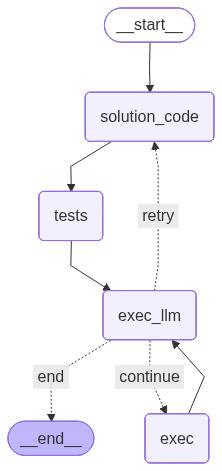

In [ ]:
import tempfile
import subprocess

@tool
def execute_code_sub(code: str = Field(description="Code to be executed.")) -> str:
    """Executes the given Python code and returns the output or error message."""
    try:
        # Create a temporary file
        with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
            f.write(code)
            temp_file = f.name
        
        # Execute the file
        result = subprocess.run(
            ['python', temp_file],
            capture_output=True,
            text=True,
            timeout=30
        )
        
        # Clean up
        import os
        os.unlink(temp_file)
        
        if result.returncode == 0:
            return "TEST_PASSED"
        else:
            return f"Error: {result.stderr.strip()}"
            
    except subprocess.TimeoutExpired:
        return "Error: Execution timed out"
    except Exception as e:
        return f"Error: {e}"


# MODEL
llm = ChatGoogleGenerativeAI(
    model=os.getenv("GOOGLE_API_MODEL"),
    temperature=0)

solution_code_model = llm.with_structured_output(SolutionCode)
test_code_model = llm.with_structured_output(TestCode)


# STATE
class ExecutionState(BaseModel):
    tests_generated: bool = Field(default=False, description="Flag indicating if tests have been generated.")
    test_code: TestCode = None
    test_status: str = Field(default="", description="Status of the test execution.")   
    solution_code: SolutionCode = None
    messages: Annotated[list[AnyMessage], add_messages]
    


# NODES
def generate_code_tests(state: ExecutionState) -> dict:
    system_message = """
    You are an expert Python programmer. Write tests that can be executed directly without needing function definitions. 
    Use print statements to show test results.
    """
    instruction_message = """
    Write python test code for the following python code. The tests should print "PASSED" if all tests pass or show the specific error if any fail.
    
    Code to test: {solution_code}
    """
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=instruction_message.format(solution_code=state.solution_code.solution_code))
    ]
    
    response = test_code_model.invoke(messages)
    return {
        "test_code": response, 
        "tests_generated": True,
        "messages": [AIMessage(content=f"Generated test code: {response.test_code}")]
    }

def generate_solution_code(state: ExecutionState) -> dict:
    response = solution_code_model.invoke(state.messages)
    return {"solution_code": response, "messages": [AIMessage(content=f"Generated solution code: {response.solution_code}")]}



def exec_llm(state: ExecutionState) -> dict:
    execution_llm = llm.bind_tools([execute_code_sub])
    
    # Build messages for the LLM
    system_message = """
    You are an expert Python code tester. Execute the test code and analyze the results.
    If tests pass, respond with "TESTS_PASSED". If tests fail, respond with "TESTS_FAILED" and the error details.
    """
    
    # Check if we have tool results to process
    tool_results = []
    for msg in state.messages:
        if isinstance(msg, ToolMessage) and msg.content:
            tool_results.append(msg.content)
    
    if tool_results:
        # We have execution results to analyze
        instruction_message = """
        Analyze these test execution results and determine if the tests passed or failed:
        
        Test Code: {test_code}
        
        Execution Results: {results}
        
        Respond with "TEST_PASSED" if all tests passed, or "TEST_FAILED" with error details if any tests failed.
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(
                test_code=state.test_code.test_code,
                results="\n".join(tool_results)
            ))
        ]
    else:
        # First call - need to execute the tests
        instruction_message = """
        Execute this test code and return the results: {test_code}
        """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=instruction_message.format(test_code=state.test_code.test_code))
        ]
    
    result = execution_llm.invoke(messages)
    return {"messages": [result]}


def conditional_edge(state: ExecutionState) -> str:
    # Look for PASSED/FAILED in recent messages
    recent_messages = state.messages[-5:]  # Check last 5 messages
    
    for msg in reversed(recent_messages):
        if hasattr(msg, 'content') and msg.content:
            content = msg.content.upper()
            if 'TEST_PASSED' in content:
                return "end"
            elif 'TEST_FAILED' in content or 'ERROR' in content:
                return "continue"
    
    # Also check if we have tool calls that need execution
    if recent_messages and hasattr(recent_messages[-1], 'tool_calls') and recent_messages[-1].tool_calls:
        return "continue"
    
    return "continue"


# GRAPH

graph = StateGraph(ExecutionState)
graph.add_node("solution_code", generate_solution_code)
graph.add_node("tests", generate_code_tests)
graph.add_node("exec_llm", exec_llm)
graph.add_node("exec", ToolNode(tools=[execute_code_sub]))

graph.add_edge(START, "solution_code")
graph.add_edge("solution_code", "tests")
graph.add_edge("tests", "exec_llm")
graph.add_edge("exec", "exec_llm")

# Modified conditional edges to properly handle the flow
graph.add_conditional_edges("exec_llm", conditional_edge, path_map={ "end": END, "retry": "solution_code", "continue": "exec" })



mbpp_graph = graph.compile()

mbpp_graph



In [102]:
# INSTRUCTIONS
system_message = """
You are an expert Python programmer. You will be provided with a task. Write a solution to the task using python. Maintain proper code structure and include comments where necessary.
"""
instruction_message = """
Write a solution for the following python task : {task}
"""


## EXECUTION
messages = [    SystemMessage(content=system_message),
                HumanMessage(content=instruction_message.format(task=df['prompt'][1])) ]

result = mbpp_graph.invoke({"messages": messages},{"recursion_limit": 15})

In [93]:
result

{'tests_generated': True,
 'test_code': TestCode(test_code='def test_find_first_repeated_char():\n    assert find_first_repeated_char("abcabc") == "a"\n    assert find_first_repeated_char("abcdef") == None\n    assert find_first_repeated_char("hello") == "l"\n    assert find_first_repeated_char("programming") == "r"\n    assert find_first_repeated_char("") == None\n    assert find_first_repeated_char("a") == None\n    assert find_first_repeated_char("aa") == "a"\n\ntest_find_first_repeated_char()\n\ndef find_first_repeated_char(s):\n    seen = set()\n    for char in s:\n        if char in seen:\n            return char\n        seen.add(char)\n    return None\n\n# The following code is to ensure that the tests run and print PASSED or the specific error\ntry:\n    test_find_first_repeated_char()\n    print("PASSED")\nexcept AssertionError as e:\n    print(f"FAILED: {e}")\nexcept Exception as e:\n    print(f"An unexpected error occurred: {e}")', description='Tests for the find_first_repe

In [27]:
assert find_first_repeated_char("abcabc") == "d"

AssertionError: 